# Report

---

In this notebook, we will see an implementation for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

## Implementation details

### Summary

The problem consists of implementing mostly-cooperative agents to play a game of Tennis.  
- 2 agents control rackets to bounce a ball over a net
- If an agent hits a ball over the net, it receives a reward of +0.1
- If an agent lets a ball hit the ground or go out of bounds, it receives a reward of -0.01.
- Episodes last until a ball hits the ground, or at most 5000 steps.
- The observation space consists of 8 variables for each agent.
- The action space consists of 2 continuous variables for each agent.

The problem is considered solved when the maximum score over both agents, averaged over 100 consecutive episodes, is at least 0.5.  However, we are going to go above and beyond and train the problem to a solved score of **1.5** instead.

We implement Multi-Agent Deep Deterministic Policy Gradient (MAADPG), presented in the paper [Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments](https://arxiv.org/abs/1706.02275).  This is a variant of the DDPG algorithm; each agent consists of a actor network and a critic network.  

Each actor network observes only the states for that agent, producing an action; each critic network observes (during training only) all states and all actions, producing a reward estimate for that agent.

Experiences for all agents and states are logged on a shared replay buffer, which is sampled at every number of steps.

### Networks

Two actor networks and two critic networks are maintained, during training, for each agent:
- Local actor network
- Target actor network
- Local critic network
- Target critic network

Updates are performed to the local network, and then to the target network, in the same manner as in single-agent DDPG.  During execution, only the local actor network is used.

#### Actor

Actor networks deterministically generate the policy that are used at execution time, taking into input only the state observable by that agent.

$$ \pi_1(s_1) = (a_{11}, a_{12}) $$
$$ \pi_2(s_2) = (a_{21}, a_{22}) $$

During training, a Ornstein–Uhlenbeck noise process is added to this generated policy, which is then clipped between -1 and 1.  The resulting policies, used during training, are:

$$ \tilde{\pi}_1(s_1) = \mathrm{clip} (\pi_1(s_1) + \epsilon_1(t), -1, 1) $$
$$ \tilde{\pi}_2(s_2) = \mathrm{clip} (\pi_2(s_2) + \epsilon_2(t), -1, 1) $$

The actor network for each agent is implemented as a two-layer fully connected neural network with batch normalization at each step, and a tanh operation at the end:

      output = nn.Sequential(
          nn.BatchNorm1d(state_size),
          nn.Linear(state_size, 64),
          nn.ReLU(),
          nn.BatchNorm1d(64),
          nn.Linear(64, 64),
          nn.ReLU(),
          nn.Linear(64, action_size),
          nn.Tanh()
      )(state)
      
The actor network is implemented in `model.py`.

#### Critic

Critic networks deterministically generated a Q-value used during training.  It takes into input the states observed by each agent, as well as the inputs generated for each agent:

$$ Q_1(s_1, s_2, \tilde{\pi}_1(s_1), \tilde{\pi}_2(s_2)) = v_1 $$
$$ Q_2(s_1, s_2, \tilde{\pi}_1(s_1), \tilde{\pi}_2(s_2)) = v_2 $$

The critic network applies a batch normalization to the state inputs, concatenates them with the action inputs, and then passes them through a fully connected network:

    normalized_states = nn.BatchNorm1d(state_size * num_agents)(states)
    concatenated_input = torch.cat((normalized_states, actions), dim=1)
    output = nn.Sequential(
        nn.Linear((state_size + action_size) * num_agents, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )(concatenated_input)
    
The critic network is implemented in `model.py`.

#### Noise process

The noise process used during training is a stateful Ornstein-Uhlenbeck process associated with each agent and action size, with drift $\mu = 0$:

    x := state
    dx := theta * (mu - x) + sigma * gaussian_noise
    state := x + dx
    return state * scale

The noise process is implemented in `noise.py`.

### Training

#### Replay buffer

We use a shared replay buffer, implemented in `memory.py`, to keep track of the observed experiences for all agents at each step:

- **state**: Tuple of states ($s_1$, $s_2$) observed by each agent
- **action**: Tuple of actions ($\tilde{\pi}_1(s_1)$, $\tilde{\pi}_2(s_2)$) selected by each agent
- **reward**: Tuple of reward values ($r_1$, $r_2$) provided to each agent
- **next_state**: Tuple of future states ($s'_1$, $s'_2$) reached by each agent after taking the actions
- **done**: Tuple of flags determining whether the agents reached a terminal state

Experiences are stored on a rolling buffer.  At each training step, a batch of random experiences (with replacement) is selected, and used on the optimization steps.

#### Loss functions

The critic loss for each agent is computed as the mean-square error between the target rewards and the expected rewards:
    
    for each agent:
        target_actions := [pi_i(next_state[i]) for i in agents]
        Q_targets_next := agent.target_critic(next_state, target_actions)
        Q_targets := rewards[agent] + gamma * Q_targets_next * (1 - done[agent])
        Q_expected := agent.critic(state, action)
        critic_loss := MSE(Q_targets, Q_expected)
        
The actor loss for each agent is computed based on the critic value:

    for each agent:
        Q_input := [pi_i(state[i]) for i in agents]
        actor_loss := -agent.critic(state, Q_input).mean()
        
Independent optimizers are used for the action and critic losses, with clipped gradient values.

#### Soft target updates

After each optimization step, a soft target update is performed on the actor and critic networks:

    target_params := target_params * (1 - tau) + local_params * tau

The training process is implemented in `ddpg.py` and `maddpg.py`.


### Hyperparameters

Agent hyperparameters may be passed as constructor arguments to `MADDPG`.  The default values, used in this workbook, are:

| parameter                      | value      | description                                                             |
|--------------------------------|------------|-------------------------------------------------------------------------|     
| actor_network_units            | (64, 64)   | Network topology for actor network function                             |
| critic_network_units           | (64, 64)   | Network topology for critic network function                            |
| optimizer_learning_rate_actor  | 1e-3       | Initial learning rate for Adam optimizers used on actor networks        |
| optimizer_learning_rate_critic | 1e-3       | Initial learning rate for Adam optimizers used on critic networks       |
| optimizer_weight_decay_actor   | 0          | Weight decay for Adam optimizers used on actor networks                 |
| optimizer_weight_decay_critic  | 0          | Weight decay for Adam optimizers used on critic networks                |
| noise_scale                    | 0.1        | Scale for the Ornstein–Uhlenbeck noise process                          |
| noise_theta                    | 0.2        | Theta parameter for the Ornstein–Uhlenbeck noise process                |
| noise_sigma                    | 0.2        | Sigma parameter for the Ornstein–Uhlenbeck noise process                |
| gamma                    | 0.99       | Discount rate for future rewards                                              |
| tau                      | 1e-3       | Scaling parameter for soft target updates                                     |
| batch_size               | 128        | Number of N-agent experiences to collect for a single optimization step       |
| update_every             | 1          | Number of steps performed between updates                                     |
| gradient_clip_actor      | 1.0        | Clipping parameter for gradient descent during actor optimization             |
| gradient_clip_critic     | 1.0        | Clipping parameter for gradient descent during critic optimization            |

Training hyperparameters are passed on the training function itself, `train_multiagent`, defined below.  The default values are:

| parameter                     | value      | description                                           |
|-------------------------------|------------|-------------------------------------------------------|
| n_episodes                    | 4000       | Maximum number of training episodes                   |
| max_t                         | 5000       | Maximum number of steps per episode                   |
| solved_score                  | 1.5        | Average score over episodes required to consider problem solved     |

## Execution

Import required system packages: 

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Let's get the state and action dimensions, and initialize our agent:

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

In [4]:
# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [5]:
from collections import deque

def train_multiagent(
    env, 
    multiagent, 
    n_episodes=1000, 
    max_t=5000, 
    display_every=10,
    solved_score=0.5, 
    save_filename=None
):
    scores = []
    scores_window = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes + 1):    
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        n_actors = len(states)
        score = np.zeros(n_actors)
        
        for t in range(max_t):
            actions = multiagent.act(states)
            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = np.array(env_info.rewards)
            dones = env_info.local_done
                        
            multiagent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += np.array(rewards)
            
            if np.any(dones):
                break

        max_score = score.max()               # get the maximum score over agents
        scores_window.append(max_score)       # save most recent score
        scores.append(max_score)              # save most recent score
        
        print('\rEpisode {}\tAverage score: {:.4f}'.format(
            i_episode, np.mean(scores_window)
        ), end="")
        if i_episode % display_every == 0:
            print('\rEpisode {}\tAverage score: {:.4f}'.format(
                i_episode, np.mean(scores_window)
            ))
            
        if np.mean(scores_window) >= solved_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage score: {:.4f}'.format(
                np.maximum(i_episode-100, 0), np.mean(scores_window))
             )
            if save_filename is not None:
                multiagent.save(save_filename)
            break
    
    return scores

In [6]:
# Initialize agent

from maddpg import MADDPG

Episode 100	Average score: 0.0018
Episode 200	Average score: 0.0000
Episode 300	Average score: 0.0030
Episode 400	Average score: 0.0000
Episode 500	Average score: 0.0030
Episode 600	Average score: 0.0110
Episode 700	Average score: 0.0230
Episode 800	Average score: 0.0280
Episode 900	Average score: 0.0597
Episode 1000	Average score: 0.0418
Episode 1100	Average score: 0.0359
Episode 1200	Average score: 0.0477
Episode 1300	Average score: 0.0525
Episode 1400	Average score: 0.1136
Episode 1500	Average score: 0.3043
Episode 1600	Average score: 0.7281
Episode 1688	Average score: 1.5006
Environment solved in 1588 episodes!	Average score: 1.5006


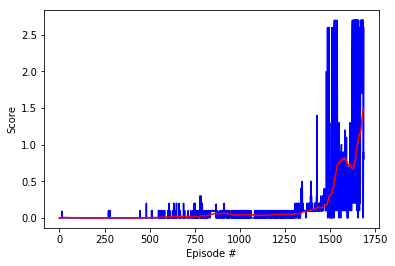

In [7]:
multiagent = MADDPG(
    state_size=state_size, 
    action_size=action_size,
    actor_network_units=(64, 64),
    critic_network_units=(64, 64),
    optimizer_learning_rate_actor=1e-3,
    optimizer_learning_rate_critic=1e-3,
    batch_size=128,
    update_every=1,
    noise_scale=0.1,
    noise_theta=0.2,
    noise_sigma=0.2
)

filename = 'checkpoint-tennis.pth'
scores = train_multiagent(
    env, 
    multiagent, 
    display_every=100, 
    n_episodes=10000,
    max_t=5000,
    solved_score=1.5, 
    save_filename=filename
)
multiagent.save(filename)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / np.append(np.array(range(n)) + 1, n * np.ones(len(ret) - n))

# plot the score and the average scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, 'b')
plt.plot(np.arange(len(moving_average(scores, n=100))), moving_average(scores, n=100), 'r')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [9]:
# Run through once with loaded model
env_info = env.reset(train_mode=False)[brain_name]            # reset the environment    
states = env_info.vector_observations                         # get the current state (for each agent)
scores = np.zeros(num_agents)                                 # initialize the score (for each agent)
for t in range(1000):
    actions = multiagent.act(states, noise=0)                 # get actions from model (for each agent)
    env_info = env.step(actions)[brain_name]                  # send all actions to tne environment
    next_states = env_info.vector_observations                # get next state (for each agent)
    rewards = env_info.rewards                                # get reward (for each agent)
    dones = env_info.local_done                               # see if episode finished
    scores += env_info.rewards                                # update the score (for each agent)
    states = next_states                                      # roll over states to next time step
    if np.any(dones):                                         # exit loop if episode finished
        break

print('Total score (averaged over agents) this episode: {}'.format(np.max(scores)))

Total score (averaged over agents) this episode: 1.600000023841858


When finished, we can close the environment:

In [ ]:
# env.close()

## Ideas for future improvement

- Use seeds for the random components in training in order to make the process reproducible
- Associate separate memory buffers with each agent in order to allow ensemble training
- Use Prioritized Experience Replay to select experiences to use in training each agent
- Perform a more complete hyperparameter search
- Try to solve the problem with other multi-agent algorithms